# kCCA Tutorial with UCI Digits Dataset

In this example, kCCA is used to project different views of a UCI dataset with handwritten digits into a common latent space. All of the views have 2000 samples. We will only be using the first two views in this tutorial. View 1 has 76 dimensions and View 2 has 216 dimensions.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append("../../..")
import numpy as np
from scipy import linalg, stats

from multiview.embed.kcca import KCCA
from multiview.embed.kcca2 import GCCA
from multiview.datasets.base import load_UCImultifeature

data = load_UCImultifeature()
views = data[0]
view_1 = views[0]
view_2 = views[1]
labels = data[1]

'''
# Center Data
view_1 = stats.zscore(view_1, axis=1, ddof=1)
mu1 = np.mean(view_1, axis=0)
view_1 -= mu1

view_2 = stats.zscore(view_2, axis=1, ddof=1)
mu2 = np.mean(view_2, axis=0)
view_2 -= mu2


nSamples = 1000

train1 = view_1[:nSamples//2]
train2 = view_2[:nSamples//2]
test1 = view_1[nSamples//2:]
test2 = view_2[nSamples//2:]
'''

train1, test1 = view_1[::2], view_1[1::2]
train2, test2 = view_2[::2], view_2[1::2]


In [6]:
gcca = GCCA()
Xs_latents1 = gcca.fit_transform([view_1, view_2], n_components=2)

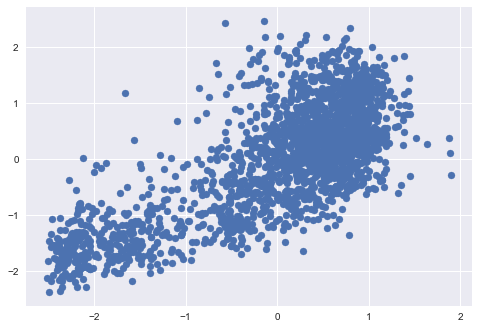

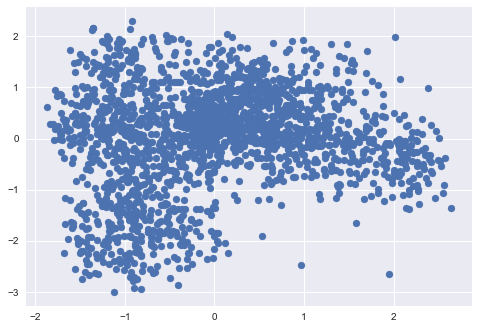

In [7]:
# Plot component 1 of view 1 and 2 into common subspace. 
# Should be a linear correlation as kcca aims to maximize the linear correlation
fig = plt.figure()
plt.scatter(Xs_latents1[0][:,0],Xs_latents1[1][:,0])
fig = plt.figure()
plt.scatter(Xs_latents1[0][:,1],Xs_latents1[1][:,1])

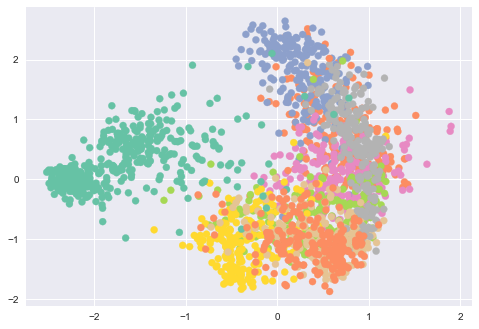

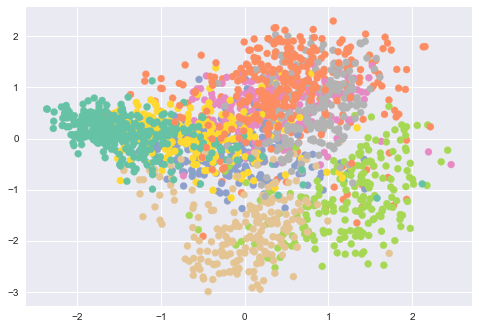

In [8]:
plt.style.use('seaborn')

color_map = [sns.color_palette("Set2", 10)[int(i)] for i in labels]

# Plot component 1 and 2 of view 1 and component 1 and 2 of view 2. Should be a similar shape.
fig = plt.figure()
plt.scatter(Xs_latents1[0][:,0],Xs_latents1[0][:,1], label = labels, color=color_map)
fig = plt.figure()
plt.scatter(Xs_latents1[1][:,0],Xs_latents1[1][:,1], label = labels, color=color_map)

## Linear Kernel

In [2]:
# Create a linear kcca object as an instantiation of the KCCA object class
kcca_l = KCCA(ktype ="linear", reg = 0.0001, n_components = 2)

# Use the train() method to find a linear projection between the two views.
kcca_l.fit_transform([view_1, view_2])

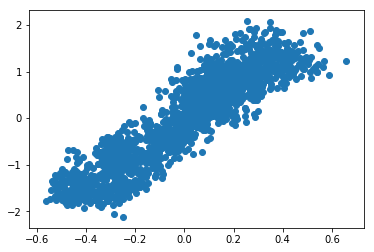

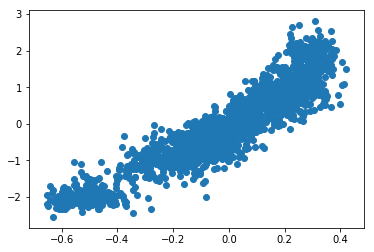

In [3]:
# Plot component 1 of view 1 and 2 into common subspace. 
# Should be a linear correlation as kcca aims to maximize the linear correlation
fig = plt.figure()
plt.scatter(kcca_l.components_[0][:,0],kcca_l.components_[1][:,0])

# Plot component 2 of view 1 and 2 into common subspace.
fig = plt.figure()
plt.scatter(kcca_l.components_[0][:,1],kcca_l.components_[1][:,1])

In [5]:
kcca_l.cancorrs_

array([0.90876916, 0.91836255])

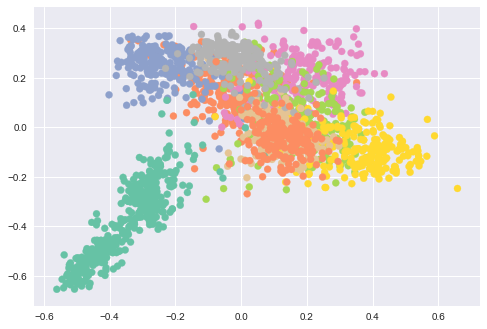

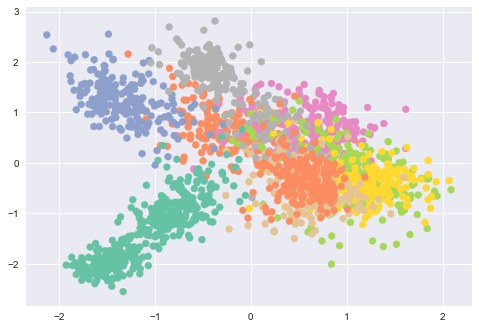

In [6]:
plt.style.use('seaborn')

color_map = [sns.color_palette("Set2", 10)[int(i)] for i in labels]

# Plot component 1 and 2 of view 1 and component 1 and 2 of view 2. Should be a similar shape.
fig = plt.figure()
plt.scatter(kcca_l.components_[0][:,0],kcca_l.components_[0][:,1], label = labels, color=color_map)
fig = plt.figure()
plt.scatter(kcca_l.components_[1][:,0],kcca_l.components_[1][:,1], label = labels, color=color_map)

In [44]:
# Call cancorrs_ to find the correlation between the two canonical components
kcca_l.cancorrs_

array([0.93904657, 0.90166838])

In [51]:
# Apply the model to the test data
testcomps1= np.dot(test1, kcca_l.ws_[0])
testcomps2= np.dot(test2, kcca_l.ws_[1])

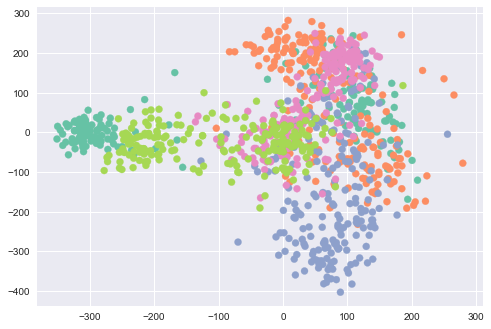

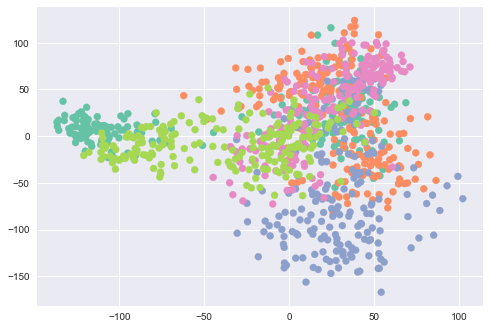

In [52]:
# Recreates the plot above
fig = plt.figure()
plt.scatter(testcomps1[:,0],testcomps1[:,1], label = labels, color=color_map)
fig = plt.figure()
plt.scatter(testcomps2[:,0],testcomps2[:,1], label = labels, color=color_map)

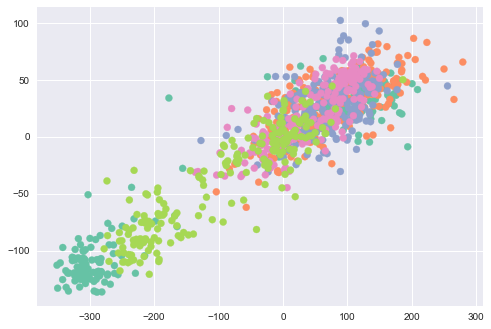

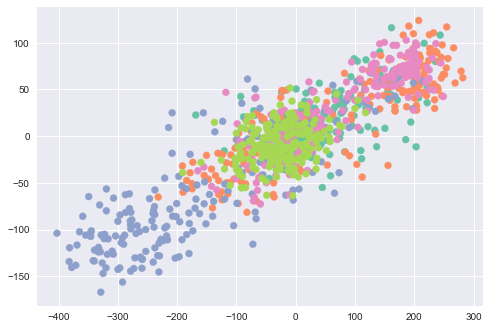

In [53]:
# Confirm linear relationship with test data
fig = plt.figure()
plt.scatter(testcomps1[:,0],testcomps2[:,0], label = labels, color=color_map)
fig = plt.figure()
plt.scatter(testcomps1[:,1],testcomps2[:,1], label = labels, color=color_map)

# Polynomial kCCA

In [9]:
# Create a polynomial kcca object as an instantiation of the KCCA object class
kcca_p5 = KCCA(ktype ="poly", reg = 0.0001, n_components = 2, degree = 3)

# Use the train() method to find a polynomial projection between the two views.
kcca_p5.fit([view_1, view_2])

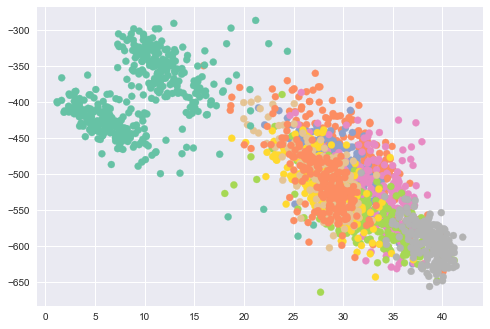

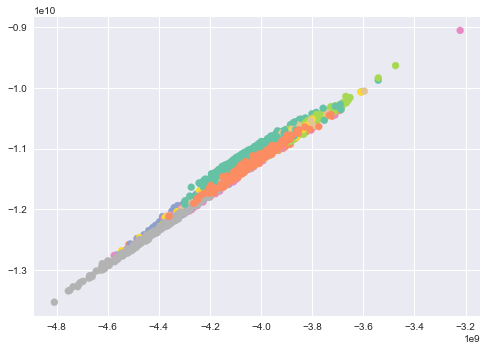

In [11]:
fig = plt.figure()
plt.scatter(kcca_p5.components_[0][:,0],kcca_p5.components_[0][:,1], label = labels, color=color_map)
fig = plt.figure()
plt.scatter(kcca_p5.components_[1][:,0],kcca_p5.components_[1][:,1], label = labels, color=color_map)

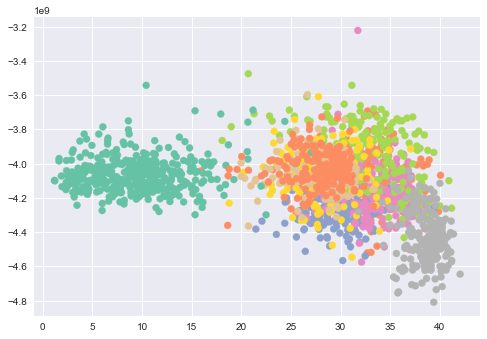

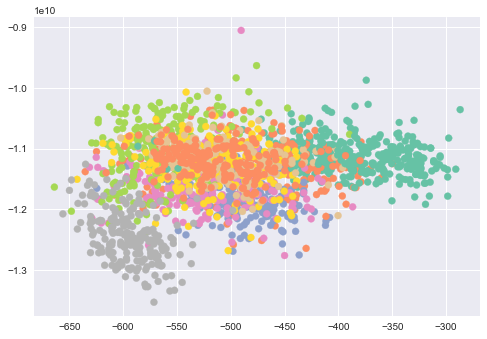

In [13]:
fig = plt.figure()
plt.scatter(kcca_p5.components_[0][:,0],kcca_p5.components_[1][:,0], label = labels, color=color_map)
fig = plt.figure()
plt.scatter(kcca_p5.components_[0][:,1],kcca_p5.components_[1][:,1], label = labels, color=color_map)

In [8]:
# Call cancorrs_ to find the correlation between the two canonical components
kcca_p5.cancorrs_

array([0.87292731, 0.56858133])

## Gaussian Kernel

In [4]:
# Create a gaussian kcca object as an instantiation of the KCCA object class
kcca_g = KCCA(ktype ="gaussian", reg = 0.0001, n_components = 2, sigma = 3)

# Use the train() method to find a gaussian projection between the two views.
kcca_g.fit([train1, train2])

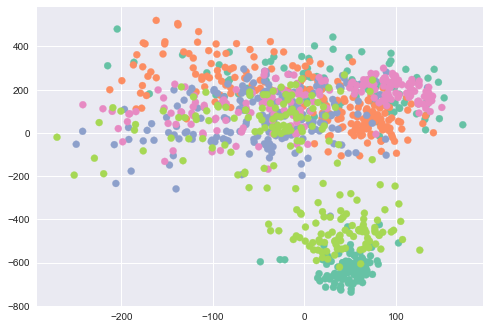

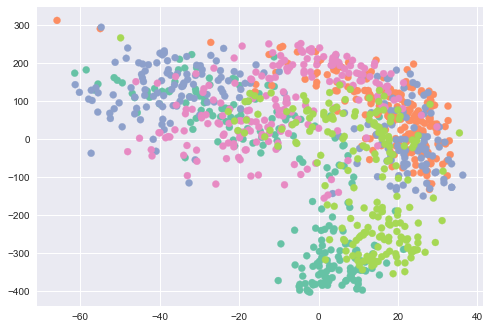

In [11]:
# Plot component 1 and 2 of view 1 and component 1 and 2 of view 2. Should be a similar shape.
fig = plt.figure()
plt.scatter(kcca_g.components_[0][:,0],kcca_g.components_[0][:,1], label = labels, color=color_map)
fig = plt.figure()
plt.scatter(kcca_g.components_[1][:,0],kcca_g.components_[1][:,1], label = labels, color=color_map)

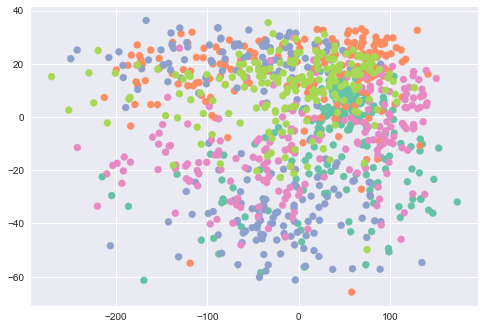

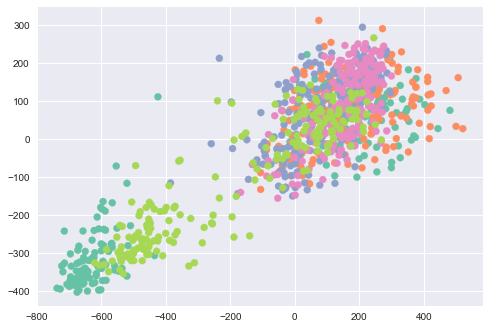

In [13]:
# Gaussian kernel is not the best as first plot isnt that linear.
fig = plt.figure()
plt.scatter(kcca_g.components_[0][:,0],kcca_g.components_[1][:,0], label = labels, color=color_map)
fig = plt.figure()
plt.scatter(kcca_g.components_[0][:,1],kcca_g.components_[1][:,1], label = labels, color=color_map)

In [61]:
# Apply the model to the test data
testcomps1= np.dot(test1, kcca_g.ws_[0])
testcomps2= np.dot(test2, kcca_g.ws_[1])

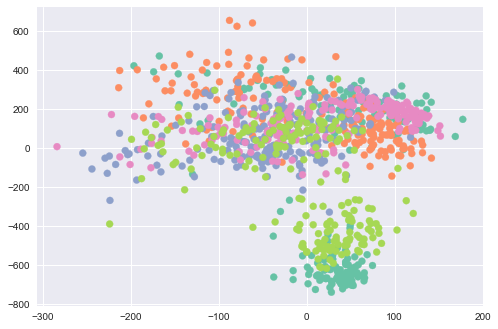

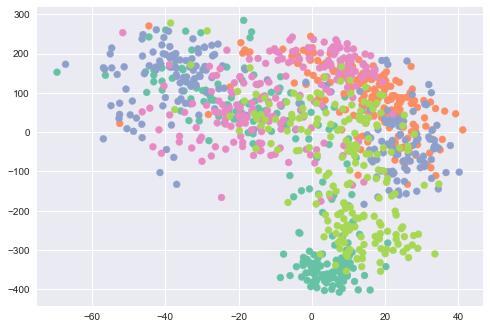

In [62]:
# Recreates the plot above
fig = plt.figure()
plt.scatter(testcomps1[:,0],testcomps1[:,1], label = labels, color=color_map)
fig = plt.figure()
plt.scatter(testcomps2[:,0],testcomps2[:,1], label = labels, color=color_map)

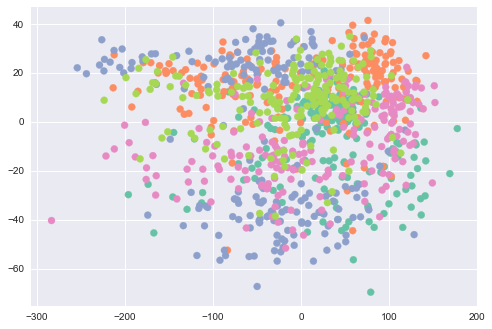

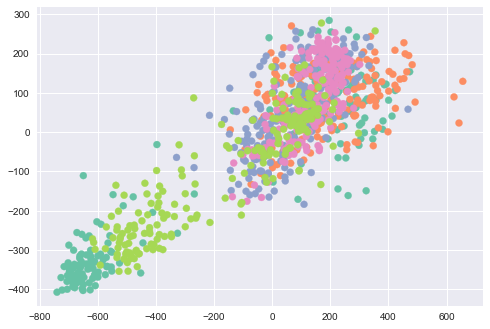

In [63]:
# Confirm linear relationship with test data. Gaussian kernel is not the best as first plot isnt that linear.
fig = plt.figure()
plt.scatter(testcomps1[:,0],testcomps2[:,0], label = labels, color=color_map)
fig = plt.figure()
plt.scatter(testcomps1[:,1],testcomps2[:,1], label = labels, color=color_map)

In [26]:
from scipy.stats import pearsonr
corr1, _ = pearsonr(kcca_g.comps_[0][:,1],kcca_g.comps_[1][:,1])
corr1

0.6342325658313278

In [30]:
# Call cancorrs_ to find the correlation between the two canonical components
kcca_g.cancorrs_

array([0.03313218, 0.8782407 ])

In [12]:
# If you are splitting test data into training and testing datasets, you can use 
# train() on the training dataset and then using validate() on the testing dataset.
# validate() will use the canonical weights on the testing data to bring the test data
# into the projected shared space.

## Plotting Together

In [13]:
list_x = [[kcca_l.comps_[0][:,0], kcca_p5.comps_[0][:,0], kcca_g.comps_[0][:,0]],
          [kcca_l.comps_[1][:,0], kcca_p5.comps_[1][:,0], kcca_g.comps_[1][:,0]]]
list_y = [[kcca_l.comps_[0][:,1], kcca_p5.comps_[0][:,1], kcca_g.comps_[0][:,1]],
          [kcca_l.comps_[1][:,1], kcca_p5.comps_[1][:,1], kcca_g.comps_[1][:,1]]]

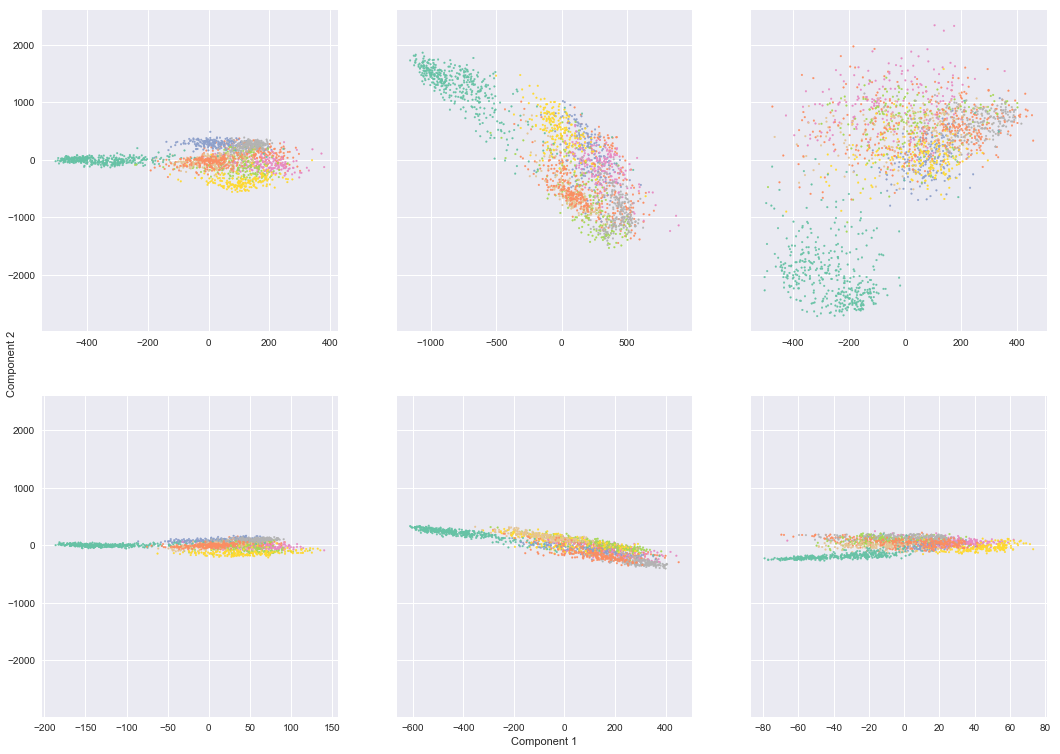

In [14]:
fig, axes = plt.subplots(2,3,figsize=(18,13), sharey=True)

for i in range(2):
    for j in range(3):
            axes[i,j].scatter(x=list_x[i][j], y=list_y[i][j], alpha=1, label=labels, color=color_map, s=3)

ax = fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
ax.grid(False)
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')

# Applying model to test data

In [15]:
nSamples = 2000
train1 = view_1[:nSamples//2]
train2 = view_2[:nSamples//2]
test1 = view_1[nSamples//2:]
test2 = view_2[nSamples//2:]

#Create a linear kcca object as an instantiation of the KCCA object class
tkcca_l = KCCA(ktype ="linear", reg = 0.0001, numCC = 2)

# Use the train() method to find a linear projection between the two views.
tkcca_l.fit([train1, train2])

# Apply model to test data to get canonical components and correlations between actual
# test data and predictions obtained by projecting the other test dataset
# via the CCA mapping for each dimension
testcomps, testcorrs = tkcca_l.fit_transform([test1, test2])